### Explore Batter Data

In [330]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import re

#Sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

#Display
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [331]:
batter_profiles = pd.read_csv('milb_batter_summaries.csv')
batter_seasons = pd.read_csv('milb_all_batter_seasons.csv')

In [332]:
len(batter_profiles.milb_id.unique())

17525

__Helper Functions__

Add Useful Data Fields

In [333]:
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_success_year(df):
    success_year = pd.DataFrame()
    success_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df


Add Stat Calulation Functions

In [334]:
## Batting Average
# Number of Hits (divided by) Number of At Bats

# Calculate the number of single from other hit data
def calc_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

def calc_BA(df):
    ba_series = df['H']/df['AB']
    return ba_series
    
## Slugging Percentage
# Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats  
def calc_SLG(df):
    slg_series = (df['1B'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']
    return slg_series

## On Base Percentage
# (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
def calc_OBP(df):
    obp_series = (df['H'] + df['BB'] + df['HBP']) \
        / (df['AB'] + df['BB'] + df['HBP']+df['SF']) 
    return obp_series

## On Base Plus Slugging 
def calc_OPS(df):
     # On Base Plus Slugging 
    ops_series = calc_OBP(df) + calc_SLG(df)
    return ops_series

Add Aggregation Function

In [335]:
# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_season_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB']
    
    
    if 'LevNum' in df.columns:
        df['LevWeight'] = df['LevNum']*df['PA']
    
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby(['milb_id','Year'])
    
    df_grouped = grouped_obj.sum()
    
    df_grouped['1B'] = calc_singles(df_grouped)
    
    # Batting Average 
    df_grouped['BA'] = calc_BA(df_grouped)
    
    # On Base Percentage
    df_grouped['OBP'] = calc_OBP(df_grouped)
    
    # Slugging Percentage
    df_grouped['SLG'] = calc_SLG(df_grouped)
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = calc_OPS(df_grouped)
    
    # Other BIO 
    # Fields where max is most important 
    test_fields = ['Age','FirstYear',
                   'SeasonNumber','SuccessYear']
    for tf in test_fields:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].max()
            
    # fields where min is most importand
    test_fields2 = ['AgeDif']
    for tf in test_fields2:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].min()
                  
    # Minor League Level Attributs
    if 'LevNum' in df.columns:
        df_grouped['LevWeighted'] = df_grouped['LevWeight']/df_grouped['PA']
        
        df_grouped['LevCount'] = grouped_obj.count()['Lev']
        df_grouped.drop('LevWeight', axis=1, inplace=True)
    
    df_grouped.reset_index(inplace=True)
    
    return df_grouped


Function for creating rate stats

In [336]:
def make_rate_stats(df):
    
    df['HR_rate'] = df['HR']/df['PA']
    df['BB_rate'] = df['BB']/df['PA']
    df['SO_rate'] = df['SO']/df['PA']
    df['IBB_rate'] = df['IBB']/df['PA']
    df['SB_rate'] = df['SB']/df['PA'] #None standard definition
    df['SB_percentage'] = df['SB']/(df['SB']+df['CS'])
    df.loc[np.isnan(df['SB_percentage']),['SB_percentage']] = 0
    
    df['GDP_rate'] = df['GDP']/df['PA']
    df['SH_rate'] = df['SH']/df['PA']
    df['SF_rate'] = df['SF']/df['PA']
    df['HBP_rate'] = df['HBP']/df['PA']
    
    
    df['SB_percentage']
    
    return df

Function to Convert Player Profile into Useful Features

In [337]:
def make_batter_profile_features(df):
    df_cleaned  = deepcopy(df)

    # --- Bats --- 
    # Try to add natural order to batting to see 
    # if it can help logistic regression too
    df_cleaned.loc[
        df_cleaned['bats'] == 'right','bats'] = 0
    df_cleaned.loc[
        df_cleaned['bats'] == 'left','bats'] = 1
    df_cleaned.loc[
        df_cleaned['bats'] == 'both','bats'] = 2

    # --- Throws --- 
    df_cleaned.loc[
        df_cleaned['throws'] == 'right','throws'] = 0
    df_cleaned.loc[
        df_cleaned['throws'] == 'left','throws'] = 1

    # --- Draft ---
    df_cleaned['draft'].fillna(value = -1, inplace=True)

    # --- Positions ---
    df_cleaned['positions'] = df['positions'].str.split(',|and')
    df_cleaned['positions'] = df_cleaned['positions'].str.get(0)
    df_cleaned['positions'] = df_cleaned['positions'].str.lower()
    df_cleaned['position_difficulty'] = df_cleaned['positions'].str.lower()

    # Crudly bin positions by value. Not specifying fielders, because older records 
    # do not designate between left, right, and center.
    pos_list = ['designated','first','fielder','third','second','catcher','shortstop']

    for p in pos_list:
        if p == 'designated':
            p_num = '0'
        elif p == 'first':
            p_num = '1'
        elif p in ['fielder','third','second']:
            p_num = '2'
        elif p in ['catcher','shortstop']:
            p_num = '3'

        df_cleaned.loc[
            df_cleaned['position_difficulty'].str.contains(p),'position_difficulty'] = p_num
        
    keep_cols = ['milb_id','draft','bats',
                     'throws','height','weight','position_difficulty']
        
    return df_cleaned[keep_cols]

Helper Function For Assessing Model Fit

In [338]:
def make_summary(pred_dict,y_test):
    summary_list = []
    for k in pred_dict.keys():
        temp_dict = {}
        temp_dict['model'] = k
        temp_dict['logloss'] = metrics.log_loss(y_test,pred_dict[k])
        temp_dict['accuracy'] = metrics.accuracy_score(
            y1_test,
            np.round(pred_dict[k][:,1]))

        # Precision Recall Metrics
        p, r, f, s = metrics.precision_recall_fscore_support(
            y_test,
            np.round(pred_dict[k][:,1]),
            labels = [0,1])
        temp_dict['precision'] = p[1]
        temp_dict['recall'] = r[1]
        temp_dict['f1'] = f[1]
        temp_dict['summprt'] = s[1]

        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        temp_dict['auc'] = metrics.auc(fpr, tpr)   

        # Append Results to List
        summary_list.append(temp_dict)

    # Put Results in DataFrame
    results1_df = pd.DataFrame(summary_list)
    results1_df.set_index(results1_df.model,inplace = True)
    return results1_df

def make_precision_recall_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        prec, recall, thresholds = metrics.precision_recall_curve(
            y_test,pred_dict[k][:,1])

        plt.plot(prec[0:-1], recall[0:-1])
        leg.append(k)

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(leg)
    plt.title('Multiple Models: Attempt 1')

def make_roc_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        plt.plot(fpr, tpr)
        leg.append(k)
        
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))    
    plt.legend(leg)
    plt.title('Multiple Models: ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

def make_feature_importance_charts(pred_dict,model_dict,X):
    num_subplots = len(pred_dict.keys())
    f, axs = plt.subplots(num_subplots,1,figsize=(20,6*num_subplots))
    f.subplots_adjust(hspace=.5)

    count = 1

    for k in pred_dict.keys():
        if 'lm' in k:
            f_Series = pd.Series(
                model_dict[k].coef_[0],index = X.columns[1:]).sort_values()
        else:
            f_Series = pd.Series(model_dict[k].feature_importances_,index = X.columns[1:]).sort_values()

        plt.subplot(num_subplots,1,count)
        g = sns.barplot(x = f_Series.index,y = f_Series)
        g.set_xticklabels(f_Series.index, rotation=-30,size=12)
        plt.title(k, size = 16)
        plt.ylabel('Feature Importance',size=14);
        plt.xlabel('Feature',size=14);
        count += 1
        

__Filtering and Aggregation__

In [339]:
batter_seasons_filt = deepcopy(batter_seasons)

# Drop Aggregated Seasons. Will Recompute
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt.Tm.str.contains('Teams') == False]

In [340]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6}
level_map = pd.Series(batter_seasons_filt.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt['LevNum'] = level_map

# Drop Leagues that are "Atypical"
weird_leagues = ['Ind','Rk','FRk','WRk','FgW','Fal','Fgn','Wtr']
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lev'].isin(weird_leagues) == False]
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lg'] != 'MEX']

In [341]:
# Remove Players Who had their first season before 1990.
batter_seasons_filt = add_season_number(batter_seasons_filt)
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] > 1990]

batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] < 2012]

In [342]:
# Remove Seasons that occured after player made the majors
majors_df = batter_seasons_filt[
    batter_seasons_filt.Lev == 'MLB'][['milb_id','Year']]

mlb_debuts = majors_df.groupby('milb_id').min().reset_index()
mlb_debuts.rename(columns={'Year':'SuccessYear'},inplace=True)

batter_seasons_filt = batter_seasons_filt.merge(
    mlb_debuts, how = 'left',on= 'milb_id')

batter_seasons_filt = batter_seasons_filt[
    (batter_seasons_filt['SuccessYear'] > batter_seasons_filt['Year']) | 
    pd.isnull(batter_seasons_filt['SuccessYear'])] 


In [343]:
batter_seasons_total = make_season_stats(batter_seasons_filt)
batter_seasons_total = make_rate_stats(batter_seasons_total)

In [344]:
## Add dependent variable
batter_seasons_total = batter_seasons_total.merge(
    batter_profiles.loc[:,['milb_id','mlb']],
    how = 'left',
    on = 'milb_id')

In [345]:
bst_test = deepcopy(batter_seasons_total)

In [346]:
bst_test = bst_test.loc[bst_test['SeasonNumber'] == 2,:]
bst_test = bst_test.loc[bst_test['PA'] > 150,:]

### Model Stuff

Start by using Features from Season Data

In [347]:
test_cols = ['milb_id','LevWeighted','AgeDif','PA',
             'BA','OBP','SLG','HR_rate',
             'BB_rate','SO_rate','IBB_rate',
             'SB_rate','SB_percentage','GDP_rate',
             'SH_rate','HBP_rate']


# test_cols = ['milb_id','LevWeighted',
#              'BA','OBP','SLG','HR_rate',
#              'BB_rate','SO_rate','IBB_rate',
#              'SB_rate','SB_percentage','GDP_rate',
#              'SH_rate','HBP_rate']


X1 = bst_test.loc[:,test_cols]
y1 = bst_test.loc[:,['mlb']]

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X1, y1, test_size=0.3)

y1_train = np.ravel(y1_train)
y1_test = np.ravel(y1_test)

In [348]:
# Baseline Prediction
#sum(y1)/len(y1)
baseline1 = sum(y1_train)/len(y1_train)
baseline1

0.24849578820697954

Try a few algorithms "out of the box," to see how they do.

In [349]:
pred_dict = {}
model_dict = {}

lm1 = linear_model.LogisticRegression()
lm1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['lm1'] = lm1.predict_proba(X1_test.iloc[:,1:])
model_dict['lm1'] = lm1

rf1 = ensemble.RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf = 5)
rf1.fit(X1_train.iloc[:,1:],y1_train)
pred_proba_rf1 = rf1.predict_proba(X1_test.iloc[:,1:])
pred_dict['rf1'] = rf1.predict_proba(X1_test.iloc[:,1:])
model_dict['rf1'] = rf1

gb1 = ensemble.GradientBoostingClassifier(
    learning_rate=.01,
    subsample=0.3,
    max_depth=4,
    n_estimators = 500)
gb1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['gb1'] = gb1.predict_proba(X1_test.iloc[:,1:])
model_dict['gb1'] = gb1

In [350]:
make_summary(pred_dict,y1_test)

,accuracy,auc,f1,logloss,model,precision,recall,summprt
model,,,,,,,,
lm1,0.802527,0.833064,0.498812,0.416619,lm1,0.673077,0.396226,530
rf1,0.813290,0.830648,0.514007,0.416824,rf1,0.725086,0.398113,530
gb1,0.808142,0.836107,0.534091,0.413076,gb1,0.671429,0.443396,530


__Look at Results of Models at Various Threasholds__

Precision and recall at 50% cutoff

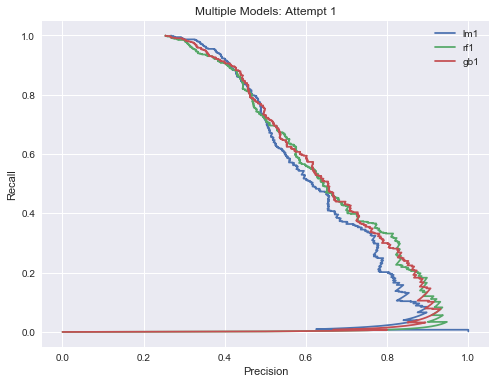

In [351]:
make_precision_recall_curves(pred_dict,y1_test)

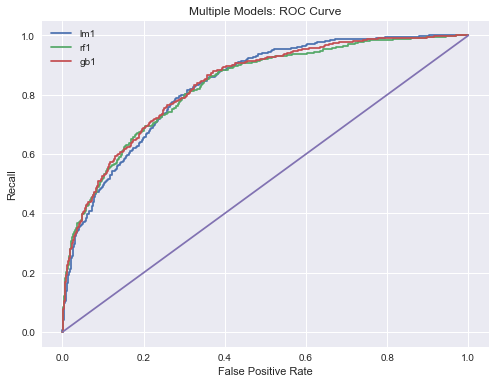

In [352]:
 make_roc_curves(pred_dict,y1_test)

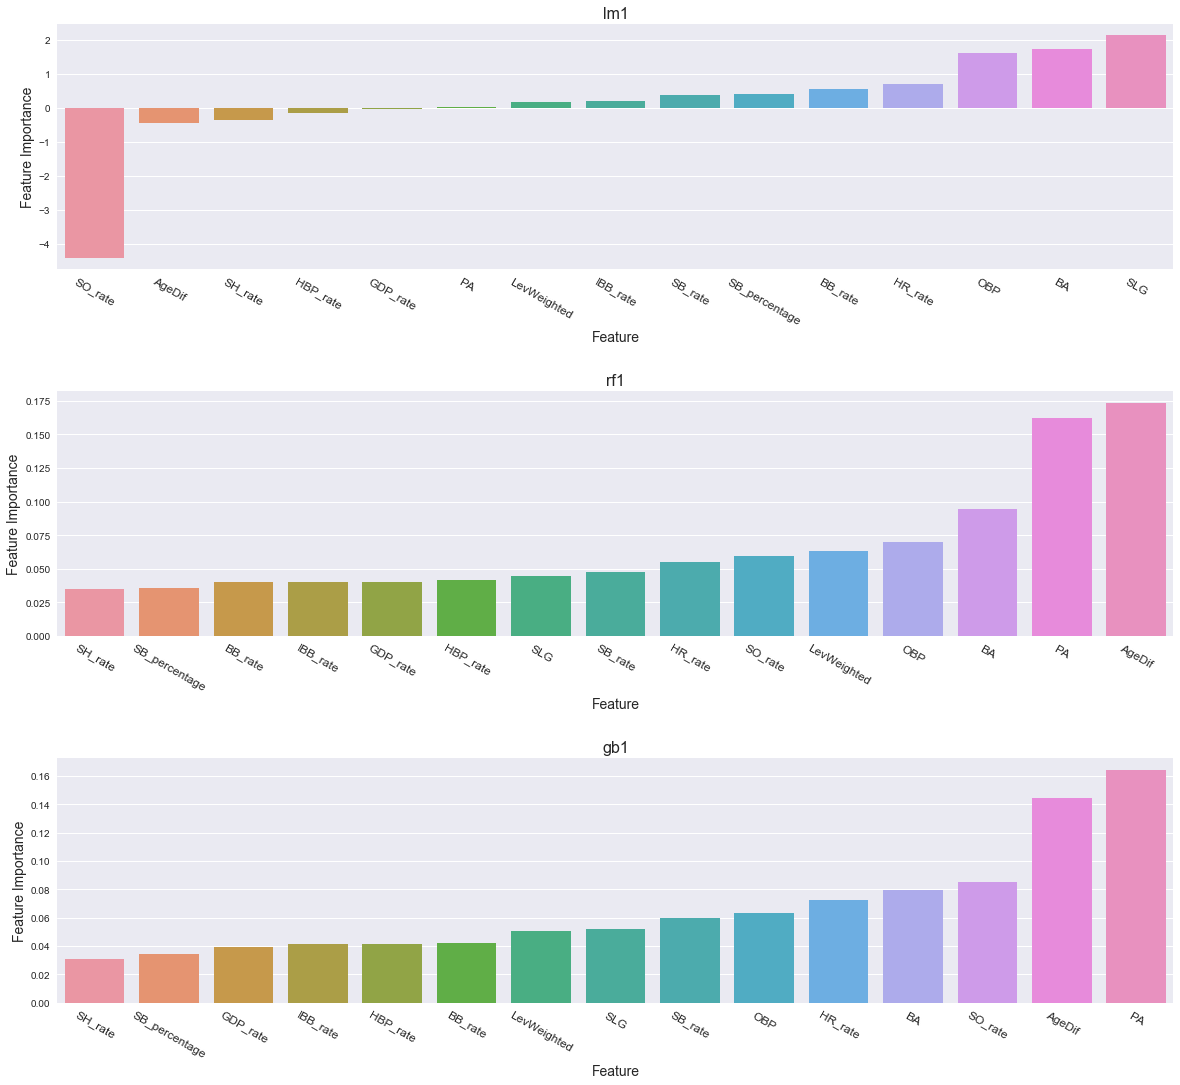

In [353]:
make_feature_importance_charts(pred_dict,model_dict,X1_test)

All models are performing about the same. However, more RF and GB trees can have additional categorical variables added to them. Moreover, Gradient descent can be used to tune these models further. 

__Add additional features from Player Profile DF__

In [354]:
batter_profile_features = make_batter_profile_features(batter_profiles)

Merge on old X1 train and test so I can have the same players in each group as before, for comparison.

In [355]:
X2_train = X1_train.merge(batter_profile_features,how='left',on='milb_id')
X2_test = X1_test.merge(batter_profile_features,how='left',on='milb_id')

# Remove Useless Features
X2_train = X2_train.drop(axis=1,labels=['bats','throws','weight'])
X2_test = X2_test.drop(axis=1,labels=['bats','throws','weight'])

In [356]:
y2_train = y1_train
y2_test = y1_test

In [357]:
lm2 = linear_model.LogisticRegression()
lm2.fit(X2_train.iloc[:,1:],y2_train)
pred_dict['lm2'] = lm2.predict_proba(X2_test.iloc[:,1:])
model_dict['lm2'] = lm2

rf2 = ensemble.RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf = 5)
rf2.fit(X2_train.iloc[:,1:],y1_train)
pred_proba_rf2 = rf2.predict_proba(X2_test.iloc[:,1:])
pred_dict['rf2'] = rf2.predict_proba(X2_test.iloc[:,1:])
model_dict['rf2'] = rf2

gb2 = ensemble.GradientBoostingClassifier(
    learning_rate=.01,
    subsample=0.3,
    max_depth=4,
    n_estimators = 500)
gb2.fit(X2_train.iloc[:,1:],y2_train)
pred_dict['gb2'] = gb2.predict_proba(X2_test.iloc[:,1:])
model_dict['gb2'] = gb2

In [358]:
summary_df = make_summary(pred_dict,y1_test)
summary_df.sort_values('logloss',ascending=True)

,accuracy,auc,f1,logloss,model,precision,recall,summprt
model,,,,,,,,
gb2,0.824052,0.853551,0.568807,0.393156,gb2,0.725146,0.467925,530
rf2,0.817969,0.843669,0.534132,0.405280,rf2,0.731148,0.420755,530
lm2,0.810482,0.842527,0.530707,0.406242,lm2,0.687688,0.432075,530
gb1,0.808142,0.836107,0.534091,0.413076,gb1,0.671429,0.443396,530
lm1,0.802527,0.833064,0.498812,0.416619,lm1,0.673077,0.396226,530
rf1,0.813290,0.830648,0.514007,0.416824,rf1,0.725086,0.398113,530


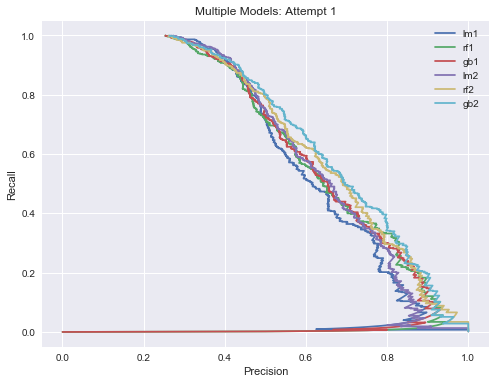

In [359]:
make_precision_recall_curves(pred_dict,y1_test)

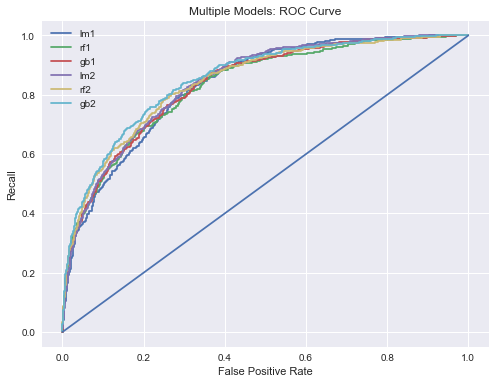

In [360]:
make_roc_curves(pred_dict,y1_test)

In [361]:
new_keys = ['lm2','rf2','gb2']
pred_dict_new =  dict([(k, pred_dict[k]) for k in new_keys ])
model_dict_new =  dict([(k, model_dict[k]) for k in new_keys])

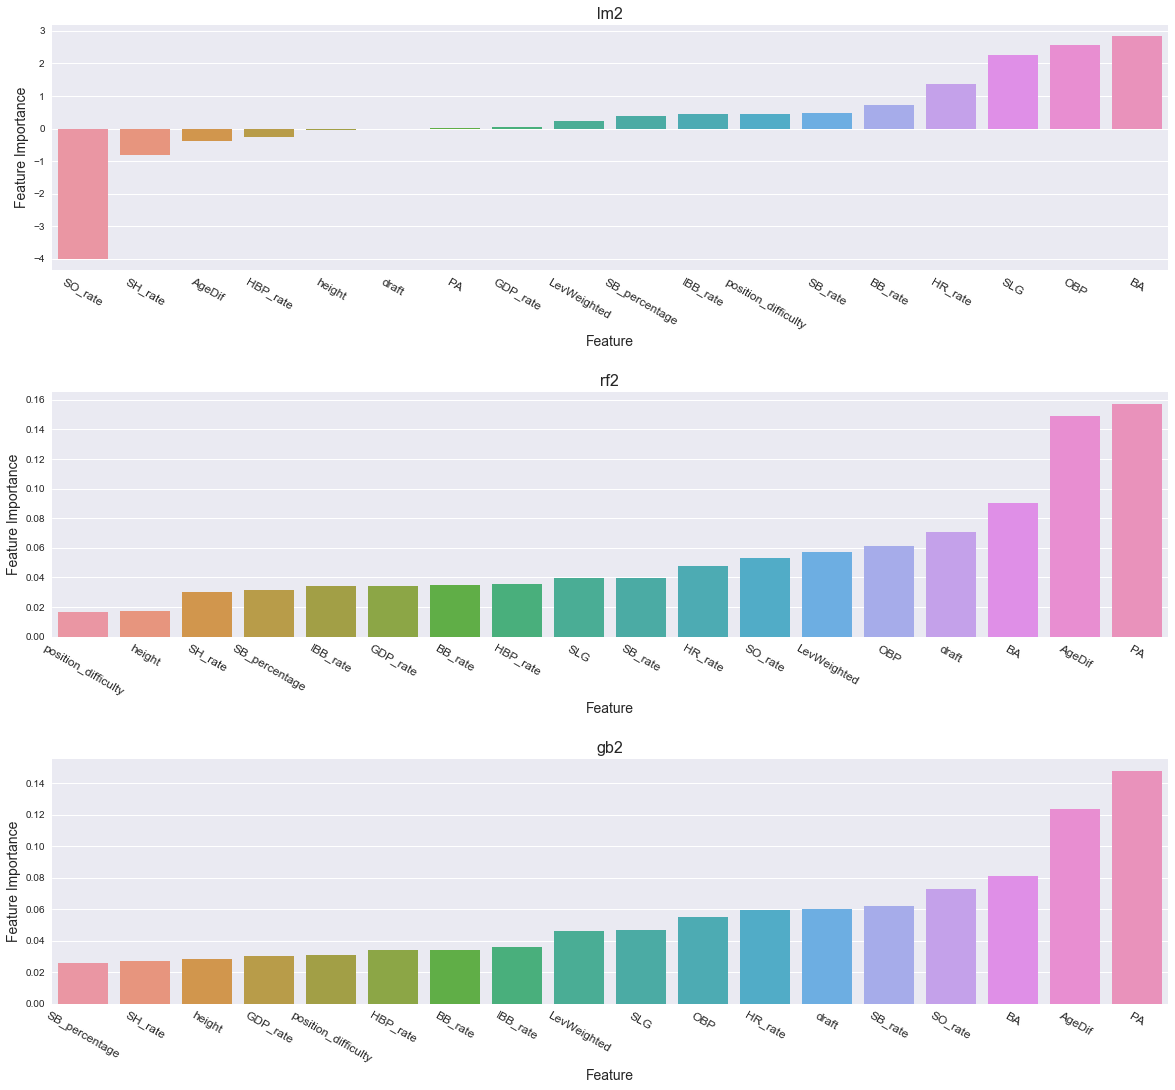

In [362]:
make_feature_importance_charts(pred_dict_new,model_dict_new,X2_test)

__ Optimize Random Forest and Gradient Boosted Trees__

It appears that gradiant boosted trees and random forest with player profile info are performing the best. Let's see if they can be further improved through grid search cross validation.

In [368]:
rf_param_grid = {'min_samples_leaf': [2, 5, 10, 15],
                 'n_estimators':[500,1000]}


rf3 = ensemble.RandomForestClassifier()
rfgs = model_selection.GridSearchCV(rf3,rf_param_grid)
rfgs.fit(X2_train.iloc[:,1:],y1_train)
pred_proba_rfgs = rfgs.predict_proba(X2_test.iloc[:,1:])
pred_dict['rfgs'] = rfgs.predict_proba(X2_test.iloc[:,1:])
model_dict['rfgs'] = rfgs
rfgs.best_estimator_

In [375]:
# gb_parameter_grid = {'learning_rate':[.01,.05,.1],
#     'subsample':[0.3,0.5,.7],
#     'max_depth':[3,5,10],
#     'n_estimators':[500,1000]}

gb_parameter_grid = {'subsample':[0.2,0.3,.5],
    'max_depth':[2,3,4,5],
    'n_estimators':[250,500,750,1000]}



gb3 = ensemble.GradientBoostingClassifier()
gbgs = model_selection.GridSearchCV(gb3,gb_parameter_grid)
gbgs.fit(X2_train.iloc[:,1:],y1_train)
pred_proba_gbgs = gbgs.predict_proba(X2_test.iloc[:,1:])
pred_dict['gbgs'] = gbgs.predict_proba(X2_test.iloc[:,1:])
model_dict['gbgs'] = gbgs                   
gbgs.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=250, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [376]:
summary_df = make_summary(pred_dict,y1_test)
summary_df.sort_values('logloss',ascending=True)

,accuracy,auc,f1,logloss,model,precision,recall,summprt
model,,,,,,,,
gb2,0.824052,0.853551,0.568807,0.393156,gb2,0.725146,0.467925,530
gbgs,0.818905,0.846418,0.576123,0.402171,gbgs,0.686684,0.496226,530
rf_gs,0.818905,0.844822,0.532044,0.404427,rf_gs,0.740741,0.415094,530
rfgs,0.822181,0.844276,0.545455,0.404964,rfgs,0.745098,0.430189,530
rf2,0.817969,0.843669,0.534132,0.405280,rf2,0.731148,0.420755,530
lm2,0.810482,0.842527,0.530707,0.406242,lm2,0.687688,0.432075,530
gb1,0.808142,0.836107,0.534091,0.413076,gb1,0.671429,0.443396,530
lm1,0.802527,0.833064,0.498812,0.416619,lm1,0.673077,0.396226,530
rf1,0.813290,0.830648,0.514007,0.416824,rf1,0.725086,0.398113,530
